<a id="title_ID"></a>
# Request a time series of a cutout of the TESS FFIs.

This notebook shows the user how to use the programmatic interface to create a cutout of the small section of the TESS FFIs. For this example we will determine the RA and Dec for TOI 109.01, which is on TIC 29344935. We then perform a query to determine which sectors contain this RA and Dec, peform a cutout of the FFI time series, open the resulting target pixel files and plot the first image of each file with the WCS overlayed on the image.  



## Import statements for this notebook.

In [1]:
import numpy as np
from astropy.io import fits
import requests
from astroquery.mast import Catalogs
import zipfile
from astropy.wcs import WCS
import matplotlib.pyplot as plt

%matplotlib inline

## Get RA and Dec of your target using astroquery Catalogs
Here we use the astroquery.mast Catalogs query_criteria function to request the RA and Dec of for the object with TIC ID = 29344935. We collect the ra and dec and store them in their own variables.

In [2]:
ticid=25155310
rad_search=1/60 #radius in degrees
catalogData=Catalogs.query_criteria(catalog="Tic",ID=str(ticid))
#catalogData = Catalogs.query_object(starName, radius=rad_search, catalog="TIC")
Ra=catalogData[0]['ra']
Dec=catalogData[0]['dec']
catalogData[0]['ID','Jmag','ra','dec','objType']

ID,Jmag,ra,dec,objType
str8,float64,float64,float64,str4
25155310,9.962,63.37389,-69.226789,STAR


## Determine which Sectors have FFI data for this target.
We use the requests module to determine which sectors/cameras/CCDs contain data for this target.

In [3]:
myparams={"ra":Ra, "dec":Dec, "radius":"0m"}
url="https://mastdev.stsci.edu/tesscut/api/v0.1/sector"

requestData=requests.get(url=url,params=myparams)

In [4]:
requestData.json()

{'results': [{'sectorName': 'tess-s0001-4-1',
   'sector': '0001',
   'camera': '4',
   'ccd': '1'},
  {'sectorName': 'tess-s0002-4-2',
   'sector': '0002',
   'camera': '4',
   'ccd': '2'}]}

This star was observed in Sector 1 and 2, on Camera 4 and CCDs 1 and 2.

## Request a 10 x 12 pixel timeseries of FFI cutouts around this star.
This delivers a zipped file containing the two cutouts, one from each sector.

In [5]:
myparams={"ra":Ra, "dec":Dec, "x":10, "y":14, \
          "access_token":"068f4303b6e64184906b22d3cf5ec389",\
           "units":"px","sector":"All"}

url="https://mastdev.stsci.edu/tesscut/api/v0.1/astrocut"

r=requests.get(url=url,params=myparams)
#Check the content type.
print(r.headers.get('content-type'))

application/zip


In [6]:
open('astrocut.zip', 'wb').write(r.content)

2641464

### Open the zip file so we can see what is in the header of the two files.
We use python's zipfile to unzip the file, but this could also be done using unzip from the command line.  

In [7]:
zipRef=zipfile.ZipFile('astrocut.zip','r')
zipRef.extractall('.')
zipRef.close()
cutoutnames = zipRef.namelist()
print(cutoutnames)

['tess-s0001-4-1_63.37389_-69.226789_14x10_astrocut.fits', 'tess-s0002-4-2_63.37389_-69.226789_14x10_astrocut.fits']


### Inspect the contents of both files.

In [8]:
file1=cutoutnames[0]
file2=cutoutnames[1]
fits.info(file1)

Filename: tess-s0001-4-1_63.37389_-69.226789_14x10_astrocut.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  PIXELS        1 BinTableHDU    244   1282R x 12C   [D, E, J, 140J, 140E, 140E, 140E, 140E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU       143   (14, 10)   float64   


In [9]:
fits.info(file2)

Filename: tess-s0002-4-2_63.37389_-69.226789_14x10_astrocut.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  PIXELS        1 BinTableHDU    244   1245R x 12C   [D, E, J, 140J, 140E, 140E, 140E, 140E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU       143   (14, 10)   float64   


In [10]:
hdu1=fits.open(file1)
hdu1[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'STScI/MAST'         / institution responsible for creating this file 
DATE    = '2018-10-24'         / file creation date.                            
TSTART  =    1325.313100604524 / observation start time in TJD                  
TSTOP   =    1353.167256127407 / observation stop time in TJD                   
DATE-OBS= '2018-07-25T19:29:

### Compare the Time of the Start of Observation for both files.
Since one is from Sector 1 and the other is from Sector 2, these are approximately a month a part. 

In [11]:
hdu2=fits.open(file2)
print("File 1 Start Time: " + hdu1[0].header['DATE-OBS'])
print("File 2 Start Time: " + hdu2[0].header['DATE-OBS'])

File 1 Start Time: 2018-07-25T19:29:42.708Z
File 2 Start Time: 2018-08-23T14:29:41.724Z


## Plot the First Image of the First Sector of Data with WCS overlay

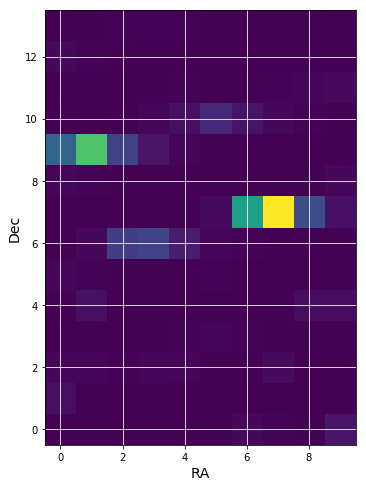

In [20]:
first_image=hdu1[1].data['FLUX'][0]
wcs=WCS(hdu1[2].header)

fig = plt.figure(figsize=(8,8))
#fig.add_subplot(111, projection=wcs)
plt.imshow(first_image, origin='lower', cmap=plt.cm.viridis)
plt.xlabel('RA',fontsize=14)
plt.ylabel('Dec',fontsize=14)
plt.grid(axis='both',color='white', ls='solid')

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 

In [22]:
first_image.shape

(14, 10)

In [19]:
hdu1[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2866 / length of dimension 1                          
NAXIS2  =                 1282 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   12 / number of table fields                         
TTYPE1  = 'TIME    '           / column name                                    
TFORM1  = 'D       '           / column format                                  
TUNIT1  = 'BJD - 2457000, days' / unit                                          
TDISP1  = 'D14.7   '           / display format                                 
TTYPE2  = 'TIMECORR'        

In [23]:
print(first_image)

[[  81.080086   81.10162    80.69666    80.70605    81.640465   95.000175
   130.54974   106.074066   96.71075   220.97847 ]
 [ 165.58958    97.43167    87.766365   90.66882    83.69548    80.56942
    79.95139    82.30616    81.4947     88.13016 ]
 [ 120.52391   123.964874  104.14032   122.45797   114.853134   91.547844
    92.477684  143.56209    82.84301    80.69736 ]
 [  80.254555   80.73904    80.385864   84.00985   101.79556   107.668625
    99.19616    94.55289    91.22163    86.42459 ]
 [  93.20463   180.9572     80.99708    80.90404    82.38653    81.45585
    81.95497    93.41579   154.5158    156.06465 ]
 [ 117.98802   100.57944    92.101036   89.70997    88.03914   101.65213
    80.60107    80.870514   82.29361    82.16634 ]
 [  87.15975   129.21667   498.90903   542.73926   250.03525   122.55352
   100.02034    96.032974   94.61947    93.00319 ]
 [  81.86777    82.98719    87.33409    85.15346    92.98778   144.36876
  1378.7523   2365.6526    616.38654   189.13184 ]
 [ 10